In [2]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import time
import threading

from tqdm import tqdm
from string_generator import (
    create_strings_from_dict,
    create_strings_from_file,
    create_strings_from_file_random,
    create_strings_from_wikipedia,
    create_strings_randomly
)
from data_generator import FakeTextDataGenerator
from multiprocessing import Pool

In [3]:
def margins(margin):
    margins = margin.split(',')
    if len(margins) == 1:
        return [margins[0]] * 4
    return [int(m) for m in margins]


def load_dict(lang):
    """
    read dictionary and return all words in it
    :return:
    """
    lang_dict = []
    with open(os.path.join('dicts', lang + '.txt'),'r',encoding='utf8',errors='ignore') as d:
        lang_dict = d.readlines()
    return lang_dict


def load_files(lang):
    """
    read files and return file path to string_generator
    :return:
    """
    if lang == 'cn':
        return [os.path.join('files/cn', file) for file in os.listdir('files/cn')]
    else:
        return [os.path.join('files/latin', file) for file in os.listdir('files/latin')]


def load_fonts(lang):
    """
    read .ttf files and return the fonts
    P.S. only Truetype is allowed
    :return:
    """
    if lang == 'cn':
        return [os.path.join('fonts/cn', font) for font in os.listdir('fonts/cn')]
    else:
        return [os.path.join('fonts/latin', font) for font in os.listdir('fonts/latin')]

In [4]:
def gen_text_img(num = 1, use_file = 0, text = None, text_length = 10, font_size = 32, font_id = 1, space_width = 0, background = 1, text_color = '#282828',
                 blur = 0.0, random_blur = False, distorsion = 0,distorsion_orientation = 0, skew_angle = 0, random_skew = 0, thread_count = 1):

    # Constant
    output_dir = 'out/'
    extension = 'jpg'
    handwritten = False
    name_format = 0
    width = -1
    alignment = 1
    orientation = 0
    margins = (5, 5, 5, 5)
    fit = False

    language = 'cn'
    lang_dict = load_dict(language)

    fonts = load_fonts(language)

    if use_file:
        file_names = load_files(language)
        if text_length==-1:
            strings = create_strings_from_file_random(file_names, num)
        else:
            strings = create_strings_from_file(file_names, text_length, num)
    else:
        # to be implemented
        # strings = create_strings_from_dict(text_length, num, lang_dict)
        if text is not None:
            strings = num*[text]
        else:
            strings = num*['你好']

    p = Pool(thread_count)
    mutex = threading.Lock()
    result = []
    for _, img in p.imap_unordered(
            FakeTextDataGenerator.generate_from_tuple,
            zip(
                [i for i in range(0, num)],
                strings,
                [fonts[font_id]] * num if font_id else [fonts[random.randrange(0, len(fonts))] for _ in range(0, num)],
                [output_dir] * num,
                [font_size] * num if font_size else [random.randrange(28, 36) for _ in range(0, num)],
                [extension] * num,
                [skew_angle] * num,
                [random_skew] * num,
                [blur] * num,
                [random_blur] * num,
                [background] * num if background>=0 else [random.randint(0, 2) for _ in range(0, num)],
                [distorsion] * num if distorsion>=0 else [random.randint(0, 2) for _ in range(0, num)],
                [distorsion_orientation] * num,
                [handwritten] * num,
                [name_format] * num,
                [width] * num,
                [alignment] * num,
                [text_color] * num,
                [orientation] * num,
                [space_width] * num,
                [margins] * num,
                [fit] * num
            )
    ):
        if mutex.acquire(1):
            result.append((_, img))
            mutex.release()

    p.terminate()
    final_image = np.concatenate([img for _, img in result], axis=1)
    df = pd.concat([meta for meta, _ in result])
    df = df.reset_index(drop=True)

    return df, final_image

In [5]:
num = 1
use_file = 0
text = None
text_length = 10
font_size = 32
font_id = 1
space_width = 1
text_color = '#282828'
thread_count = 8

# skew & blur 
"""
    If random_xxx is set True, the following variable decides the range.
    If random_xxx is set True, the following variable decides the constant.
    The variable should be set in NON-NEGATIVE INTEGER.
    skew_angle is better not be greater than 3.
    blur is better not be greater than 2.   
"""
random_skew = False
skew_angle = 1
random_blur = False
blur = 0

#distorsion & background 
"""
    distorsion: 0: None (Default), 1: Sine wave, 2: Cosine wave, -1: Random
    background: 0: Gaussian Noise, 1: Plain white, 2: Quasicrystal, -1:Random
"""
distorsion = -1
distorsion_orientation = 0
background = -1

start_time = time.time()
df, target = gen_text_img(num, use_file, text, text_length, font_size, font_id, space_width, background, text_color,
                          blur,random_blur, distorsion,distorsion_orientation, skew_angle, random_skew, thread_count)
cv2.imwrite(os.path.join('out/' + 'target.jpg'), target)
end_time = time.time()
print('time for synthesize %d image is %f'%(num,end_time - start_time))


time for synthesize 1 image is 0.201129


In [6]:
display(df.head(5))
print(target.shape)

,index,text,text_length,img_shape,font_size,font_id,skew_angle,blur,distorsion_type,background_type
0,0,你好,2,43,32,FZKaiTi,1,0,Sine wave,Plain white


(32, 43, 3)


In [7]:
import matplotlib.pyplot as plt
from skimage import transform,data
import pandas as pd
from PIL import Image

text_ = ['你好']*11
float_ = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
int_ = [0,1,2,3,4,5,6,7,8,9,10]
formats = pd.DataFrame({'blur': float_,'text': text,'skew_angle': int_})
n_ = formats.shape[0]

imgs = []
for r in range(n_):
    _, img = gen_text_img(**dict(formats.iloc[r]))
    img =Image.fromarray(img).convert('RGB')
    imgs.append(img) 


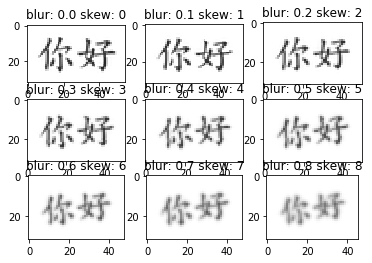

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=3)
axs = axs.flatten()
for r, (ax, img) in enumerate(zip(axs, imgs)):
    ax.imshow(img)
    ax.set_title(f'blur: {formats.iloc[r].blur} skew: {formats.iloc[r].skew_angle}')

In [9]:
text = ['你好']*3
formats = pd.DataFrame({'text': text, 'background':[0,1,2]})
imgs = []
for r in range(len(text)):
    _, img = gen_text_img(**dict(formats.iloc[r]))
    img =Image.fromarray(img).convert('RGB')
    imgs.append(img) # **dict(formats.iloc[r])

(55, 32)
(55, 32)
(55, 32)


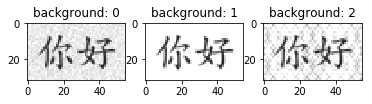

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=1)
axs = axs.flatten()
for r, (ax, img) in enumerate(zip(axs, imgs)):
    print(img.size)
    ax.imshow(img)
    ax.set_title(f'background: {formats.iloc[r].background}')

(146, 32)
(113, 32)
(113, 32)
(146, 32)
(153, 32)
(153, 32)
(146, 32)
(118, 32)
(118, 32)


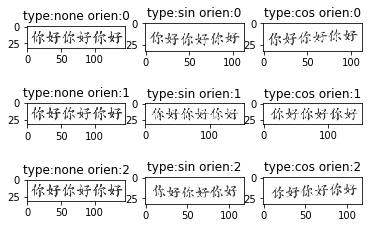

In [11]:
text = ['你好你好你好']*9
type = ['none','sin','cos','none','sin','cos','none','sin','cos']
formats = pd.DataFrame({'text': text,'distorsion': [0,1,2,0,1,2,0,1,2],'distorsion_orientation':[0,0,0,1,1,1,2,2,2]})
imgs = []
for r in range(len(text)):
    _, img = gen_text_img(**dict(formats.iloc[r]))
    img =Image.fromarray(img).convert('RGB')
    imgs.append(img) # **dict(formats.iloc[r])
    
fig, axs = plt.subplots(ncols=3, nrows=3)
axs = axs.flatten()
# print(f'now return value type is : {type(axs)}' )
for r, (ax, img) in enumerate(zip(axs, imgs)):
    print(img.size)
    ax.imshow(img)
    ax.set_title(f'type:{type[r]} orien:{formats.iloc[r].distorsion_orientation}')